In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
from astropy.stats import LombScargle
from astropy.stats import sigma_clip
from scipy.stats import mode
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.linalg import lstsq
from astropy.io import fits
import astropy.units as u
import h5py
from scipy.interpolate import griddata
# from echelle import plot_echelle, interact_echelle
#import plotutils

import lightkurve as lk
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve
from lightkurve.utils import plot_image

# from halophot.halo_tools import halo_tpf

# from tessbkgd.tessbkgd import bkgd_tpf
import tessbkgd

from lightkurve import MPLSTYLE

In [2]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=22              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [3]:
target = "iot Dra"

In [4]:
search = lk.search_targetpixelfile(target)

In [5]:
search

#,observation,target_name,productFilename,distance
0,TESS Sector 15,165722603,tess2019226182529-s0015-0000000165722603-0151-s_tp.fits,0.0
1,TESS Sector 16,165722603,tess2019253231442-s0016-0000000165722603-0152-s_tp.fits,0.0
2,TESS Sector 22,165722603,tess2020049080258-s0022-0000000165722603-0174-s_tp.fits,0.0
3,TESS Sector 23,165722603,tess2020078014623-s0023-0000000165722603-0177-s_tp.fits,0.0
4,TESS Sector 24,165722603,tess2020106103520-s0024-0000000165722603-0180-s_tp.fits,0.0


In [6]:
tpf = search[1].download()

In [7]:
tpf.__class__ = tessbkgd.tessbkgd.bkgd_tpf

In [8]:
newbkgd = tpf.get_bkgd()

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/tim/anaconda3/lib/python3.7/site-packages/tessbkgd-0.1-py3.7.egg/tessbkgd/tessbkgd.py:34: RuntimeWarning: invalid value encountered in greater
/home/tim/anaconda3/lib/python3.7/site-packages/tessbkgd-0.1-py3.7.egg/tessbkgd/tessbkgd.py:35: RuntimeWarning: invalid value encountered in less


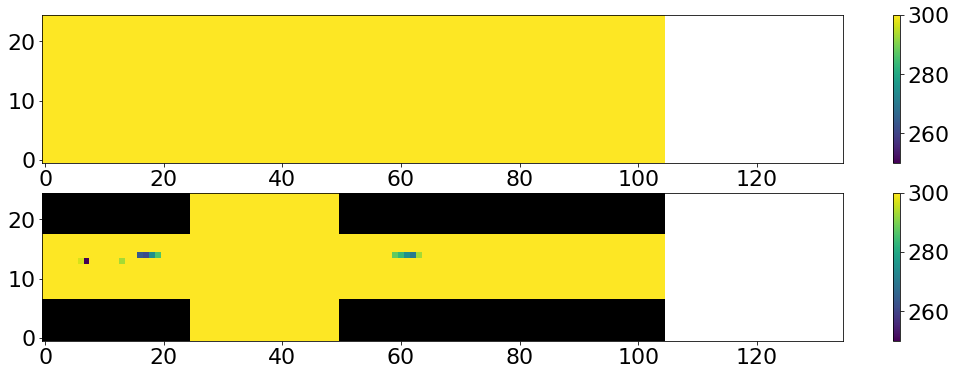

In [9]:
fig,axes = plt.subplots(2,1,figsize=(18,6))

xl=-0.5,134.5
asp = 1
frame = 8250
cmax = 300
cmin = 250

cmap = mpl.cm.viridis
# norm = np.size(newmask)
cmap.set_bad('k',1.)
im = ((newbkgd[frame,:,:]).T)
# plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
#     interpolation='None',origin='lower')
img = axes[0].imshow(im,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
axes[0].set_xlim(xl)
plt.colorbar(img, ax=axes[0])

im2 = (((tpf.flux[frame,:,:]+tpf.flux_bkg[frame,:,:])).T)
# plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
#     interpolation='None',origin='lower')
img = axes[1].imshow(im2,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
axes[1].set_xlim(xl)
plt.colorbar(img, ax=axes[1])

plt.show()

In [10]:
tpf.flux = tpf.flux + tpf.flux_bkg - newbkgd
tpf.flux_bkg = newbkgd

In [11]:
from scipy.ndimage.morphology import binary_dilation

In [12]:
sapmask = tpf.create_threshold_mask(threshold=50)
sapmask = binary_dilation(sapmask)
sapmask = binary_dilation(sapmask)

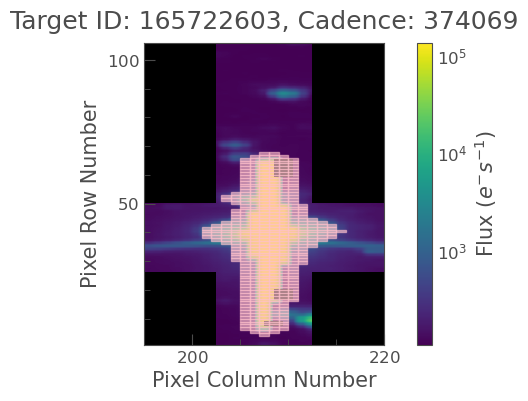

In [13]:
tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = sapmask)
plt.show()

In [14]:
# tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = tpf.pipeline_mask)
# plt.show()

In [15]:
lc = tpf.extract_aperture_photometry(aperture_mask=sapmask)
# lc2 = tpf.extract_aperture_photometry(aperture_mask=tpf.pipeline_mask)

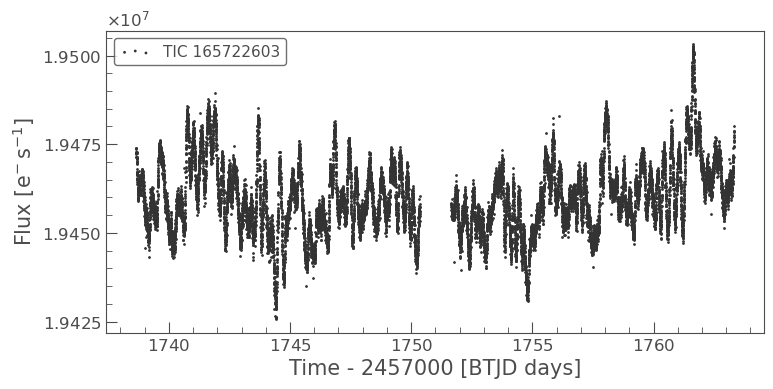

In [16]:
lc.scatter()

In [17]:
# lc2.scatter()

In [18]:
tpf.to_fits(output_fn='iotDra_Sector16.fits')

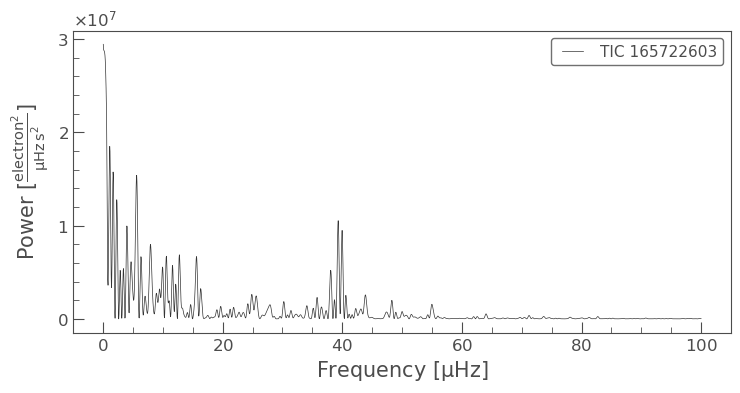

In [19]:
pg = lc.remove_nans().remove_outliers().to_periodogram(normalization='psd', oversample_factor=10, maximum_frequency = 100)
pg.plot()
# plt.xlim(0,20)